Basically, this project is to simulate the Long-Short Equity Strategy by using ranking algorithm on stocks. 



we collect desired EOD data from Yahoo (thanks to auquantoolbox, I did not run into any issues under python 3.6 since it says only Python 2.7 would work on the official site) .

The raw data contains columns including Date, Open, High, Low, Close, Adj Close and volume. Then, the code only took Adj close column as useful information and it got transformed into momentum and returns. 

The key concept of this ranking scheme is using Spearman rank package in scipy.stats package, in which positive correlations imply that as x increases, so does y (here x is 30 days Momentum Scores and y equals to 5 days forward returns by Stock).

In [1]:
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import scipy.spatial.distance as distance
import scipy
from statsmodels import regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [43]:
## PROBLEM SETUP ##
# Generate stocks and a random factor value for them
stock_names = ['stock ' + str(x) for x in range(10000)]
current_factor_values = np.random.normal(0, 1, 10000)
# Generate future returns for these are dependent on our factor values
future_returns = current_factor_values + np.random.normal(0, 1, 10000)
# Put both the factor values and returns into one dataframe
data = pd.DataFrame(index = stock_names, columns=['Factor Value','Returns'])
data['Factor Value'] = current_factor_values
data['Returns'] = future_returns
# Take a look
data.head(10)

,Factor Value,Returns
stock 0,0.138272,-0.737290
stock 1,-0.852561,0.001349
stock 2,-0.411358,-0.585241
stock 3,-0.883550,-1.781389
stock 4,-1.243626,-0.810370
stock 5,0.669083,0.739852
stock 6,0.757363,0.229840
stock 7,-0.071621,-0.218654
stock 8,-0.134977,1.144584
stock 9,-1.024107,-0.440958


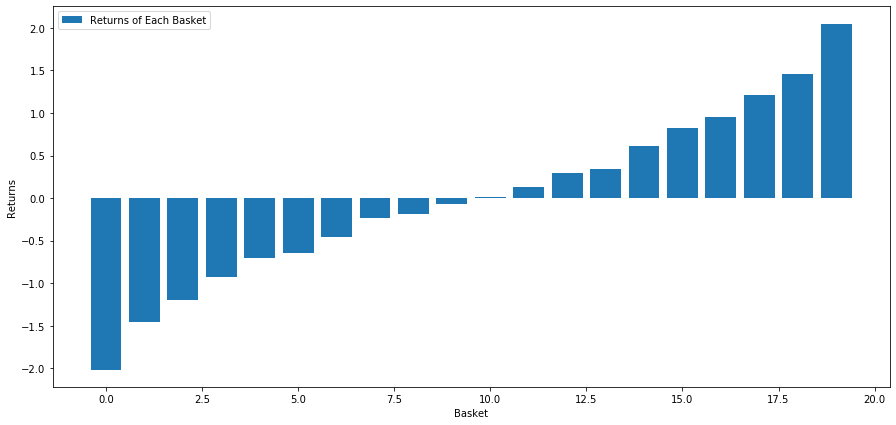

In [44]:
# Rank the equities
ranked_data = data.sort_values('Factor Value')

# Compute the returns of each basket with a basket size 500, so total (10000/500) baskets
number_of_baskets = int(10000/500)
basket_returns = np.zeros(number_of_baskets)

for i in range(number_of_baskets):
    start = i * 500
    end = i * 500 + 500 
    basket_returns[i] = ranked_data[start:end]['Returns'].mean()

# Plot the returns of each basket
plt.figure(figsize=(15,7))
plt.bar(range(number_of_baskets), basket_returns)
plt.ylabel('Returns')
plt.xlabel('Basket')
plt.legend(['Returns of Each Basket'])
plt.show()

In [45]:
basket_returns[number_of_baskets-1] - basket_returns[0]

4.067282807299395

In [2]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

startDateStr = '2012/01/01'
endDateStr = '2016/12/31'
cachedFolderName = '/Users/xinchenyuan/Desktop/'
dataSetId = 'testLongShortTrading'
instrumentIds = ['ABT','AKS','AMGN','AMD','AXP','BK','BSX',
                'CMCSA','CVS','DIS','EA','EOG','GLW','HAL',
                'HD','LOW','KO','LLY','MCD','MET','NEM',
                'PEP','PG','M','SWN','T','TGT',
                'TWX','TXN','USB','VZ','WFC']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                             dataSetId=dataSetId,
                             instrumentIds=instrumentIds,
                             startDateStr=startDateStr,
                             endDateStr=endDateStr,
                             event='history')

price = 'adjClose'

Processing data for stock: ABT
Processing data for stock: AKS
Processing data for stock: AMGN
Processing data for stock: AMD
Processing data for stock: AXP
Processing data for stock: BK
Processing data for stock: BSX
Processing data for stock: CMCSA
Processing data for stock: CVS
Processing data for stock: DIS
Processing data for stock: EA
Processing data for stock: EOG
Processing data for stock: GLW
Processing data for stock: HAL
Processing data for stock: HD
Processing data for stock: LOW
Processing data for stock: KO
Processing data for stock: LLY
Processing data for stock: MCD
Processing data for stock: MET
Processing data for stock: NEM
Processing data for stock: PEP
Processing data for stock: PG
Processing data for stock: M
Processing data for stock: SWN
Processing data for stock: T
Processing data for stock: TGT
Processing data for stock: TWX
Processing data for stock: TXN
Processing data for stock: USB
Processing data for stock: VZ
Processing data for stock: WFC
10% done...
20%

In [18]:
## Load relevant prices in a dataframe

data = ds.getBookDataByFeature()['adjClose']

data

,ABT,AKS,AMGN,AMD,AXP,BK,BSX,CMCSA,CVS,DIS,...,PG,M,SWN,T,TGT,TWX,TXN,USB,VZ,WFC
2012-01-03,22.961781,8.460762,53.798233,5.480000,43.278912,17.627291,5.360000,10.681801,35.373497,34.506126,...,52.245857,25.055613,32.700001,20.072723,40.589706,34.829899,24.122398,22.969845,27.943628,22.896170
2012-01-04,22.872713,8.727321,53.504524,5.460000,43.305847,17.687452,5.310000,10.782076,35.612045,34.992508,...,52.222401,25.032610,33.400002,20.105755,39.700417,34.983299,23.968390,22.961514,27.577890,23.000856
2012-01-05,22.820084,8.579232,54.049976,5.460000,43.808567,17.833551,5.340000,10.877998,35.569447,35.577961,...,52.003498,26.006311,33.650002,20.085934,38.517338,35.270901,24.138617,23.302986,27.387989,23.371323
2012-01-06,22.613623,8.638468,54.343685,5.430000,43.332775,17.575726,5.300000,10.764640,35.322380,35.947258,...,51.878414,26.497007,33.200001,19.898220,38.866714,35.040798,24.138617,23.111427,27.309618,23.306904
2012-01-09,22.609575,8.559487,53.873756,5.590000,43.440495,17.945280,5.350000,10.991351,35.603531,35.803139,...,52.097321,26.420332,33.080002,19.884808,38.564987,35.290100,24.446625,23.519522,27.338114,23.596819
2012-01-10,22.714828,8.895154,55.107300,5.710000,43.691853,18.306253,5.530000,11.074194,35.739845,35.695053,...,51.854958,26.734673,32.509998,19.951849,38.739666,35.443501,24.860014,23.536177,27.480612,23.685411
2012-01-11,22.629080,9.655338,55.719894,5.810000,43.943207,18.478146,5.540000,11.082912,35.816513,34.857403,...,51.346821,26.711674,29.920000,20.106050,38.930229,35.817299,24.908651,23.661108,27.715733,23.854544
2012-01-12,22.522917,9.408525,56.676544,5.820000,44.571629,18.701599,5.560000,11.117790,35.910229,34.884415,...,51.448456,26.865013,29.770000,20.193201,39.549557,36.056999,25.427412,23.935947,27.729979,23.846481
2012-01-13,22.633163,8.993879,56.726887,5.660000,44.670368,18.435165,5.520000,11.065474,35.910229,34.587189,...,51.448456,26.389666,29.420000,20.159685,39.557503,35.731098,25.086973,24.177473,27.729979,23.846481
2012-01-17,22.747494,8.954389,57.121284,5.730000,45.083313,18.280468,5.530000,11.135235,36.242500,34.659245,...,51.800243,26.589010,29.150000,20.280363,39.605137,35.769402,25.184240,23.960932,27.801231,24.023659


In [5]:
def momentum(dataDf, period):
    return dataDf.sub(dataDf.shift(period), fill_value=0) / dataDf.iloc[-1]

def ewm(dataDf, halflife):
    return dataDf.ewm(halflife=halflife,ignore_na=False,min_periods=0,adjust=True).mean()

def rsi(data, period):
    data_upside = data.sub(data.shift(1), fill_value=0)
    data_downside = data_upside.copy()
    data_downside[data_upside > 0] = 0
    data_upside[data_upside < 0] = 0
    avg_upside = data_upside.rolling(period).mean()
    avg_downside = - data_downside.rolling(period).mean()
    rsi = 100 - (100 * avg_downside / (avg_downside + avg_upside))
    rsi[avg_downside == 0] = 100
    rsi[(avg_downside == 0) & (avg_upside == 0)] = 0

    return rsi

In [6]:
len(data.index)

1905

In [8]:
#Let's load momentum score and returns into separate dataframes
index = data.index
#mscores = pd.DataFrame(index=index,columns=assetList)
mscores = momentum(data, 30)
#returns = pd.DataFrame(index=index,columns=assetList)
day = 30
mscores.head().columns

Index(['ABT', 'AKS', 'AMGN', 'AMD', 'AXP', 'BK', 'BSX', 'CMCSA', 'CVS', 'DIS',
       'EA', 'EOG', 'GLW', 'HAL', 'HD', 'LOW', 'KO', 'LLY', 'MCD', 'MET',
       'NEM', 'PEP', 'PG', 'M', 'SWN', 'T', 'TGT', 'TWX', 'TXN', 'USB', 'VZ',
       'WFC'],
      dtype='object')

In [13]:
# Calculate Forward returns
forward_return_day = 5
returns = data.shift(-forward_return_day)/data -1
returns.dropna(inplace = True)

returns.head()

,ABT,AKS,AMGN,AMD,AXP,BK,BSX,CMCSA,CVS,DIS,...,PG,M,SWN,T,TGT,TWX,TXN,USB,VZ,WFC
2012-01-03,-0.010755,0.051342,0.024333,0.041971,0.009541,0.038518,0.031716,0.036735,0.010357,0.034456,...,-0.007482,0.067013,-0.005810,-0.006022,-0.045579,0.017617,0.030578,0.024655,-0.016570,0.034470
2012-01-04,-0.010652,0.106335,0.041405,0.064103,0.014718,0.044704,0.043315,0.027901,0.005742,-0.003861,...,-0.016766,0.067075,-0.104192,0.000015,-0.019400,0.023840,0.039229,0.030468,0.004998,0.037115
2012-01-05,-0.013022,0.096663,0.048595,0.065934,0.017418,0.048675,0.041199,0.022044,0.009581,-0.019494,...,-0.010673,0.033019,-0.115305,0.005340,0.026799,0.022287,0.053391,0.027162,0.012487,0.020331
2012-01-06,0.000864,0.041143,0.043854,0.042357,0.030868,0.048899,0.041509,0.027946,0.016642,-0.037835,...,-0.008288,-0.004051,-0.113855,0.013140,0.017773,0.019700,0.039288,0.046126,0.015392,0.023151
2012-01-09,0.006100,0.046136,0.060280,0.025045,0.037818,0.018678,0.033645,0.013091,0.017947,-0.031950,...,-0.005702,0.006384,-0.118803,0.019892,0.026971,0.013582,0.030172,0.018768,0.016940,0.018089


32


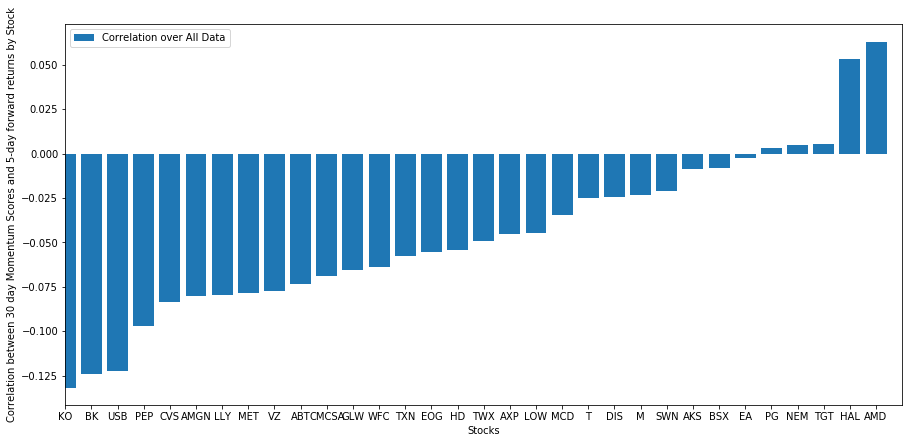

In [17]:
# Calculate correlations between momentum and returns
correlations = pd.DataFrame(index = returns.columns, columns = ['Scores', 'pvalues'])
mscores = mscores[mscores.index.isin(returns.index)]
for i in correlations.index:
    score, pvalue = stats.spearmanr(mscores[i], returns[i])
    correlations['pvalues'].loc[i] = pvalue
    correlations['Scores'].loc[i] = score
correlations.dropna(inplace = True)
correlations.sort_values('Scores', inplace=True)
#print(correlations)
l = correlations.index.size
plt.figure(figsize=(15,7))
plt.bar(range(1,1+l),correlations['Scores'])
plt.xlabel('Stocks')
plt.xlim((1, l+1))
plt.xticks(range(1,1+l), correlations.index)
plt.legend(['Correlation over All Data'])
plt.ylabel('Correlation between %s day Momentum Scores and %s-day forward returns by Stock'%(day,forward_return_day));
#plt.show()

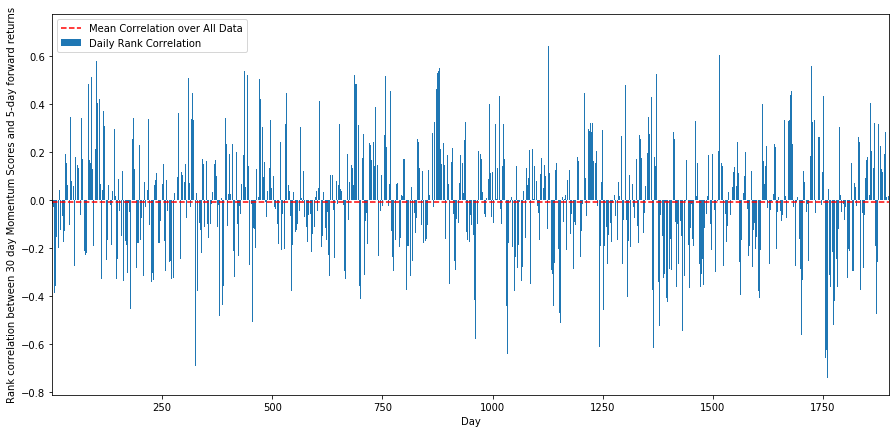

In [110]:
# 
correl_scores = pd.DataFrame(index = returns.index.intersection(mscores.index), columns = ['Scores', 'pvalues'])
for i in correl_scores.index:
    score, pvalue = stats.spearmanr(mscores.loc[i], returns.loc[i])
    correl_scores['pvalues'].loc[i] = pvalue
    correl_scores['Scores'].loc[i] = score
correl_scores.dropna(inplace = True)    

l = correl_scores.index.size
plt.figure(figsize=(15,7))
plt.bar(range(1,1+l),correl_scores['Scores'])
plt.hlines(np.mean(correl_scores['Scores']), 1,l+1, colors='r', linestyles='dashed')
plt.xlabel('Day')
plt.xlim((1, l+1))
plt.legend(['Mean Correlation over All Data', 'Daily Rank Correlation'])
plt.ylabel('Rank correlation between %s day Momentum Scores and %s-day forward returns'%(day,forward_return_day));
plt.show()

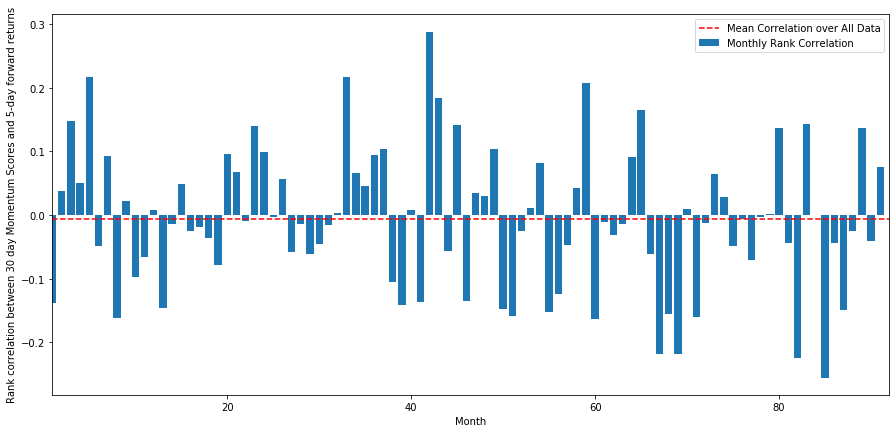

In [111]:
monthly_mean_correl =correl_scores['Scores'].astype(float).resample('M').mean()
plt.figure(figsize=(15,7))
plt.bar(range(1,len(monthly_mean_correl)+1), monthly_mean_correl)
plt.hlines(np.mean(monthly_mean_correl), 1,len(monthly_mean_correl)+1, colors='r', linestyles='dashed')
plt.xlabel('Month')
plt.xlim((1, len(monthly_mean_correl)+1))
plt.legend(['Mean Correlation over All Data', 'Monthly Rank Correlation'])
plt.ylabel('Rank correlation between %s day Momentum Scores and %s-day forward returns'%(day,forward_return_day));
plt.show()

In [112]:
def compute_basket_returns(factor, forward_returns, number_of_baskets, index):

    data = pd.concat([factor.loc[index],forward_returns.loc[index]], axis=1)
    # Rank the equities on the factor values
    data.columns = ['Factor Value', 'Forward Returns']
    data.sort_values('Factor Value', inplace=True)
    # How many equities per basket
    equities_per_basket = np.floor(len(data.index) / number_of_baskets)

    basket_returns = np.zeros(number_of_baskets)

    # Compute the returns of each basket
    for i in range(number_of_baskets):
        start = i * equities_per_basket
        if i == number_of_baskets - 1:
            # Handle having a few extra in the last basket when our number of equities doesn't divide well
            end = len(data.index) - 1
        else:
            end = i * equities_per_basket + equities_per_basket
        # Actually compute the mean returns for each basket
        #s = data.index.iloc[start]
        #e = data.index.iloc[end]
        basket_returns[i] = data.iloc[int(start):int(end)]['Forward Returns'].mean()
        
    return basket_returns


[0.00011246 0.00052691 0.00112426 0.00056685 0.00077043 0.00096564
 0.00051596 0.00021099]


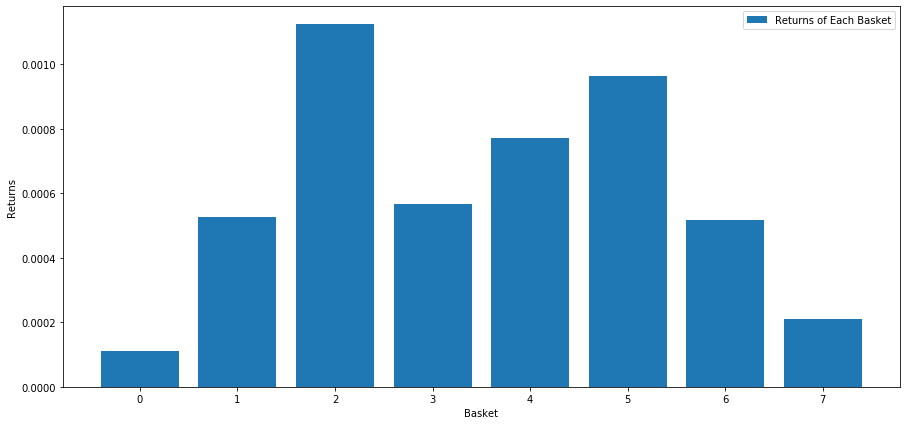

In [113]:
number_of_baskets = 8
mean_basket_returns = np.zeros(number_of_baskets)
resampled_scores = mscores.astype(float).resample('2D').last()
resampled_prices = data.astype(float).resample('2D').last()
resampled_scores.dropna(inplace=True)
resampled_prices.dropna(inplace=True)
forward_returns = resampled_prices.shift(-1)/resampled_prices -1
forward_returns.dropna(inplace = True)

for m in forward_returns.index.intersection(resampled_scores.index):
    basket_returns = compute_basket_returns(resampled_scores, forward_returns, number_of_baskets, m)
    mean_basket_returns += basket_returns

mean_basket_returns /= l    
print(mean_basket_returns)
# Plot the returns of each basket
plt.figure(figsize=(15,7))
plt.bar(range(number_of_baskets), mean_basket_returns)
plt.ylabel('Returns')
plt.xlabel('Basket')
plt.legend(['Returns of Each Basket'])
plt.show()

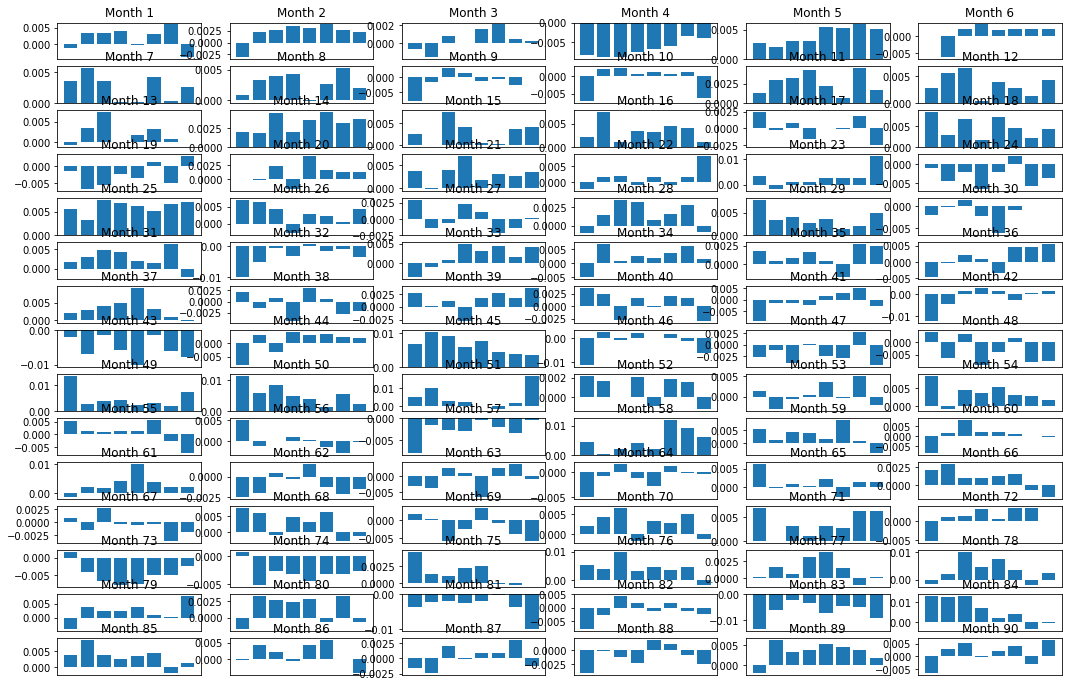

In [114]:
total_months = mscores.resample('M').last().index
months_to_plot = total_months.size
monthly_index = total_months[:months_to_plot]
mean_basket_returns = np.zeros(number_of_baskets)
strategy_returns = pd.Series(index = monthly_index)
f, axarr = plt.subplots(int(monthly_index.size/6), 6,figsize=(18, 12))
for month in range(1, monthly_index.size):
    temp_returns = forward_returns.loc[monthly_index[month-1]:monthly_index[month]]
    temp_scores = resampled_scores.loc[monthly_index[month-1]:monthly_index[month]]
    for m in temp_returns.index.intersection(temp_scores.index):
        basket_returns = compute_basket_returns(temp_scores, temp_returns, number_of_baskets, m)
        mean_basket_returns += basket_returns
    
    strategy_returns[monthly_index[month-1]] = mean_basket_returns[ number_of_baskets-1] - mean_basket_returns[0]
    
    mean_basket_returns /= temp_returns.index.intersection(temp_scores.index).size
    
    r = int(np.floor((month-1) / 6))
    c = (month-1) % 6
    axarr[r, c].bar(range(number_of_baskets), mean_basket_returns)
    axarr[r, c].xaxis.set_visible(False)
    axarr[r, c].set_title('Month ' + str(month))
plt.show()
        

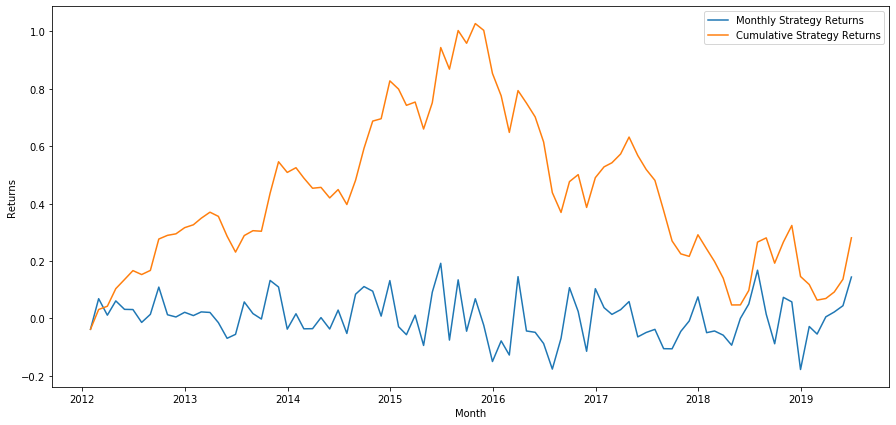

In [115]:
plt.figure(figsize=(15,7))
plt.plot(strategy_returns)
plt.ylabel('Returns')
plt.xlabel('Month')
plt.plot(strategy_returns.cumsum())
plt.legend(['Monthly Strategy Returns','Cumulative Strategy Returns'])
plt.show()

In [117]:
total_return = strategy_returns.sum()
ann_return = 100*((1 + total_return)**(12.0 /float(strategy_returns.index.size))-1)
print('Annual Returns: %.2f%%'%ann_return)

Annual Returns: 3.32%


In [118]:
np.random.normal(0, 1, 10000)

array([-0.45912781,  0.25674412, -0.8858818 , ..., -0.24733984,
        0.95999831, -0.88470969])

An interesting finding is that the mean correlation over all data is mostly a perfect straight line which indicates no trivial correlation over the years and the number is bit lower than 0. Then the last step is calculating the basket returns.


One little question about the ranking system: should we assume our datasets are normally distributed? If so, can we use Pearson ranking instead of Spearman method.


The next possible step could be using more different techniques to test out the ones with better results, such as combination of value factors, technical indicators, pricing models.
